In [1]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import math
import numpy as np
from PIL import Image         
import cv2                 
import matplotlib.pyplot as plt
from os import getcwd
import csv
# Fix error with TF and Keras
import tensorflow as tf

In [12]:
def process_img_for_visualization(image, angle, pred_angle, frame):
    '''
    Used by visualize_dataset method to format image prior to displaying. Converts colorspace back 
    to original BGR, applies text to display steering angle and frame number (within batch to be visualized), 
    and applies lines representing steering angle and model-predicted steering angle (if available) to image.
    '''    
    font = cv2.FONT_HERSHEY_SIMPLEX
    img = cv2.cvtColor(image, cv2.COLOR_YUV2RGB)
    img = cv2.resize(img,None,fx=3, fy=3, interpolation = cv2.INTER_CUBIC)
    h,w = img.shape[0:2]
    # apply text for frame number and steering angle
    cv2.putText(img, 'frame: ' + str(frame), org=(2,18), fontFace=font, fontScale=.5, color=(200,100,100), thickness=1)
    cv2.putText(img, 'angle: ' + str(angle), org=(2,33), fontFace=font, fontScale=.5, color=(200,100,100), thickness=1)
    # apply a line representing the steering angle
    cv2.line(img,(int(w/2),int(h)),(int(w/2+angle*w/4),int(h/2)),(0,255,0),thickness=4)
    if pred_angle is not None:
        cv2.line(img,(int(w/2),int(h)),(int(w/2+pred_angle*w/4),int(h/2)),(0,0,255),thickness=4)
    return img
    
def visualize_dataset(image_batch,angle_batch,predicted_angle=None):
    '''
    format the data from the dataset (image, steering angle) and display
    '''
    new_images = []
    for i in range(len(image_batch)):
        if predicted_angle is not None:
            img = process_img_for_visualization(image_batch[i], angle_batch[i], predicted_angle[i], i)
        else: 
            img = process_img_for_visualization(image_batch[i], angle_batch[i], None, i)
        
        new_images.append(img)
    
    return np.array(new_images)

# CAREFUL!! All preprocessing need to be done in drive.py too. or somehow in the real images.
# This should be done
def preprocess_image(img):
    '''
    Adds gaussian blur and transforms BGR to YUV. 
    '''
    new_img = cv2.GaussianBlur(img, (3,3), 0)
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2YUV)
    return new_img

def random_distortion(img):
    ''' 
    method for adding random distortion to dataset images, including random brightness adjust, and a random
    vertical shift of the horizon position
    '''
    new_img = img.astype(float)
    
    # Add random brightness
    value = np.random.randint(-28, 28)
    new_img[:,:,0] = np.minimum(np.maximum(new_img[:,:,0],0),255)
    
    # Add random shadow covering the entire height but random width
    img_height, img_width = new_img.shape[0:2]
    middle_point = np.random.randint(0,img_width)
    darkening = np.random.uniform(0.6,0.8)
    if np.random.rand() > .5:
        new_img[:,0:middle_point,0] *= darkening
    else:
        new_img[:,middle_point:img_width,0] *= darkening
        
    # Applying a perspective transform at the beginning of the horizon line
    horizon = 2*img_height/5    # Assumes horizon to be located at 2/5 of image height
    v_shift = np.random.randint(-img_height/8,img_height/8)   # Shifting horizon by up to 1/8
    pts1 = np.float32([[0,horizon],[img_width,horizon],[0,img_height],[img_width,img_height]])
    pts2 = np.float32([[0,horizon+v_shift],[img_width,horizon+v_shift],[0,img_height],[img_width,img_height]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    new_img = cv2.warpPerspective(new_img,M,(img_width,img_height), borderMode=cv2.BORDER_REPLICATE)
    return new_img.astype(np.uint8)

def generate_training_data(image_paths, angles, batch_size=128, validation_flag=False):
    '''
    method for the model training data generator to load, process, and distort images, then yield them to the
    model. if 'validation_flag' is true the image is not distorted. also flips images with turning angle magnitudes of greater than 0.33, as to give more weight to them and mitigate bias toward low and zero turning angles
    '''
    image_paths, angles = shuffle(image_paths, angles)
    X,y = ([],[])
    while True:       
        for i in range(len(angles)):
            img = cv2.imread(image_paths[i])
            angle = angles[i]
            img = preprocess_image(img)
            if not validation_flag:
                img, angle = random_distort(img, angle)
            X.append(img)
            y.append(angle)
            if len(X) == batch_size:
                yield (np.array(X), np.array(y))
                X, y = ([],[])
                image_paths, angles = shuffle(image_paths, angles)
            # flip horizontally and invert steer angle, if magnitude is > 0.33
            if abs(angle) > 0.33:
                img = cv2.flip(img, 1)
                angle *= -1
                X.append(img)
                y.append(angle)
                if len(X) == batch_size:
                    yield (np.array(X), np.array(y))
                    X, y = ([],[])
                    image_paths, angles = shuffle(image_paths, angles)


def generate_data(image_paths, angles, batch_size=20, validation_flag=False):
    '''
    Loads, preprocess and distorts images batch.
    If 'validation_flag' is true the image is not distorted.
    '''
    image_batch = []
    label_batch = []
    image_paths, angles = shuffle(image_paths, angles)
    for i in range(batch_size):
        img = cv2.imread(image_paths[i])
        angle = angles[i]
        img = preprocess_image(img)
        if not validation_flag:
            img = random_distortion(img)
        image_batch.append(img)
        label_batch.append(angle)
    return np.array(image_batch), np.array(label_batch)

In [ ]:
data_folder = './data3'
samples = []
with open(data_folder + '/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        # TODO: Check if there is a header
        # TODO: Append only if speed is over a given threshold. This means we were actually driving.
        samples.append(line)

# Remove head line
samples = samples[1:]

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                source_path = data_folder + '/IMG/'+batch_sample[0].split('/')[-1]
                center_image = mpimg.imread(source_path)
                center_angle = float(batch_sample[3])
                
                # Randomly flipping the image to augment data
                if np.random.random_sample() >= 0.5:
                    center_image = np.fliplr(center_image)
                    center_angle = -center_angle
                
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

In [3]:
data_folder = './data'

image_paths = []
steering_angles = []

minimum_speed = 0.1

with open(data_folder + '/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if line[0] == 'center':
            # Ignore header
            continue
        else:
            if float(line[6]) > minimum_speed:
                # get center image path and angle
                source_path = data_folder + '/IMG/'+line[0].split('/')[-1]
                image_paths.append(source_path)
                steering_angles.append(float(line[3]))
                # get left image path and angle
                source_path = data_folder + '/IMG/'+line[1].split('/')[-1]
                image_paths.append(source_path)
                steering_angles.append(float(line[3])+0.25)
                # get left image path and angle
                source_path = data_folder + '/IMG/'+line[2].split('/')[-1]
                image_paths.append(source_path)
                steering_angles.append(float(line[3])-0.25)
                
image_paths = np.array(image_paths)
steering_angles = np.array(steering_angles)

print('Samples in dataset:', image_paths.shape[0])

Samples in dataset: 24108


## Using a histogram to analyze the distribution of training steering angles

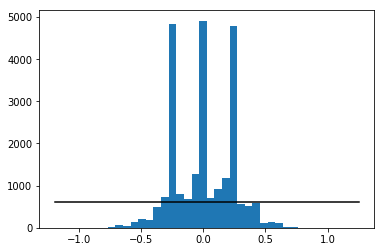

In [4]:
# Number of bins was determined experimentally
num_bins = 40
hist, bins = np.histogram(steering_angles, num_bins)
avg_samples_per_bin = np.mean(hist)
plt.hist(steering_angles, bins=num_bins)
plt.plot((np.min(steering_angles), np.max(steering_angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()

In [5]:
# First, determine keep probability for each bin. If number of samples is larger than avg, we will remove
# proportionally to the number of samples above the average; otherwise we keep all samples.
new_target_avg = avg_samples_per_bin * 1.0
keep_probs = []
for i in range(num_bins):
    if hist[i] < new_target_avg:
        keep_probs.append(1.)
    else:
        keep_probs.append(1./(hist[i]/new_target_avg))

In [6]:
idx_to_remove = []
for i in range(len(steering_angles)):
    for j in range(num_bins):
        if steering_angles[i] > bins[j] and steering_angles[i] <= bins[j+1]:
            # Delete with probability 1-keep_prob
            if np.random.rand() > keep_probs[j]:
                idx_to_remove.append(i)

In [7]:
image_paths = np.delete(image_paths, idx_to_remove, axis=0)
steering_angles = np.delete(steering_angles, idx_to_remove)

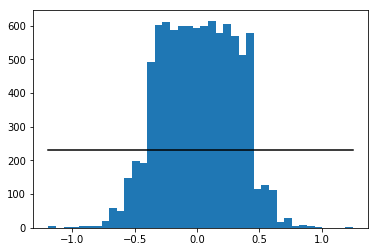

In [8]:
hist, bins = np.histogram(steering_angles, num_bins)
avg_samples_per_bin = np.mean(hist)
plt.hist(steering_angles, bins=num_bins)
plt.plot((np.min(steering_angles), np.max(steering_angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()

In [19]:
# visualize a single batch of the data
image_batch, label_batch = generate_data(image_paths, steering_angles, batch_size=1)
img_temp = visualize_dataset(image_batch,label_batch,)

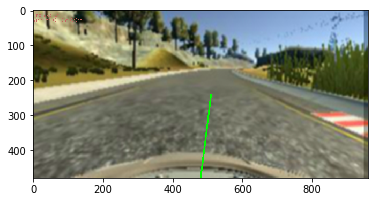

In [20]:
plt.imshow(img_temp[0,:])
plt.show()